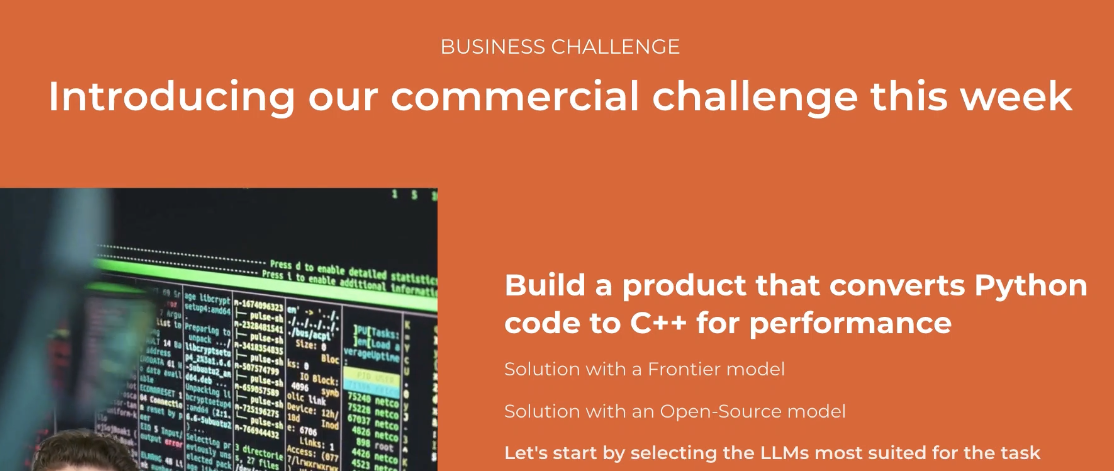

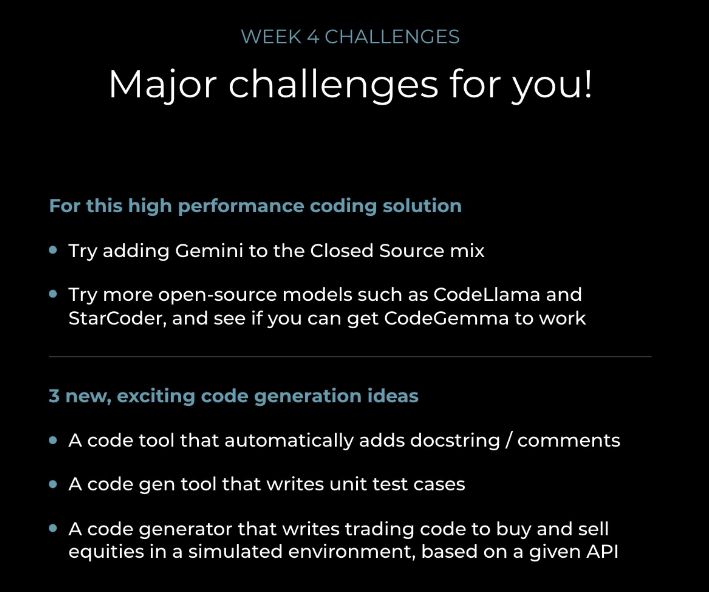

# Trading Code Generation

**Description**: Use LLM to write trading code to buy and sell equities in a simulated (Paper trading) environment, based on an API.

Assumptions:


*   `tickers` is a list of stock tickers (strings), representing available stocks to trade.
*   `prices` is a dictionary where: (1) The key is a stock ticker (string). AND (2) The value is a list of historical prices (floats), ordered with the most recent price first.
*   `Trade` is a class that represents a trading decision. It takes two arguments: (1) `ticker`: A string representing the stock ticker. AND (2) `quantity`: An integer representing the number of shares to buy (positive) or sell/short (negative).



Imports

In [87]:
!pip -q install gradio
!pip -q install huggingface_hub
!pip -q install transformers
!pip -q install anthropic

In [104]:
pip install --upgrade gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 105.4 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.10.1
    Uninstalling gradio_client-1.10.1:
      Successfully uninstalled gradio_client-1.10.1
  Attempting uninstall: gradio
    Found existing installation: gradio 5.31.0
    Uninstalling gradio-5.31.0:
      Successfully uninstalled gradio-5.31.0


In [26]:
from alpaca.data.requests import StockLatestTradeRequest
import gradio as gr
from huggingface_hub import login, InferenceClient
from transformers import AutoTokenizer
from google.colab import userdata
import anthropic

Set up models and API Keys

In [27]:
anthropic_api_key = userdata.get('ANTHROPIC_API_KEY')
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [28]:
# Open-source LLM Models
code_qwen = "Qwen/CodeQwen1.5-7B-Chat"
CODE_QWEN_URL = "https://yyiiw7960w2ozttm.us-east-1.aws.endpoints.huggingface.cloud"

In [29]:
# Closed-source LLM Models
CLAUDE_MODEL = "claude-sonnet-4-20250514"

Build model

In [30]:
MAX_TOKENS = 2000

In [31]:
SYSTEM_PROMPT = """
You are an advanced code generation assistant capable of creating high-quality Python code for financial trading systems.
Your task is to generate Python functions that simulate trading decisions based on the following API:

API DETAILS:
1. tickers: A list of stock tickers (strings) representing available stocks.
2. prices: A dictionary where the key is a stock ticker (string) and the value is a list of historical prices (floats). The list is ordered with the most recent price first.
3. Trade: A class used to represent trading actions.
   - `Trade(ticker, quantity)` creates a trade object:
     - Positive `quantity` (e.g., `100`) represents buying shares.
     - Negative `quantity` (e.g., `-50`) represents selling/shorting shares.

Example Function:
# tickers is a list of stock tickers (strings)
import tickers

# prices is a dict; the key is a ticker and the value is a list of historic prices, today first
import prices

# Trade represents a decision to buy or sell a quantity of a ticker
# Trade("IBM", 100) for a trade object representing purchasing 100 shares of IBM stock
# Trade("IBM", -50) for a trade object representing selling or shorting 50 shares of IBM stock
import Trade

import random
import numpy as np

def trade1():
    # Buy top performing stock in the last 5 days
    avg_prices = {ticker: np.mean(prices[ticker][:5]) for ticker in tickers}
    best_ticker = max(avg_prices, key=avg_prices.get)
    trade = Trade(best_ticker, 100)
    return [trade]

INSTRUCTIONS:
- You will be provided with a message by the user asking you to generate Python functions to simulate a trading strategy.
- Your job is to generate 2 Python functions, one implementing the user's requested trading strategy and the other a trading strategy you think is better than the one provided based on your knowledge and expertise.
- Ensure the functions are named sequentially (e.g., `trade1()`, `trade2()`, etc.).
- Include clear comments explaining the logic behind each function.
- Return a list of `Trade` objects from each function.
- The output should only include the Python code. Do not include any introductions, conclusions, summaries, or additional context.

"""

In [32]:
def user_prompt(user_strategy):
  return f"{user_strategy} based on the user strategy, write a python code that would simulate that strategy \
  and another function that would be an improvement on this one based on your knowledge and expertise. Make sure each function has clear comments explaining the logic and return a list of Trade objects."

In [33]:
# Define Claude's function for generating the code
def claude_trade(user_strategy):
  client = anthropic.Anthropic(api_key=anthropic_api_key)
  result = client.messages.stream(
          model=CLAUDE_MODEL,
          max_tokens=MAX_TOKENS,
          system=SYSTEM_PROMPT,
          messages=[{"role": "user", "content": user_prompt(user_strategy)}],
      )
  reply = ""
  with result as stream:
      for text in stream.text_stream:
          reply += text
          yield reply.replace("```python\n", "").replace("```", "")

In [34]:
# Define Qwen's function for generating the code
def qwen_trade(user_strategy):
  tokenizer = AutoTokenizer.from_pretrained(code_qwen)
  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_prompt(user_strategy)}
  ]
  text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  client = InferenceClient(CODE_QWEN_URL, token=hf_token)
  stream = client.text_generation(text, stream=True, details=True, max_new_tokens=MAX_TOKENS)
  result = ""
  for r in stream:
      result += r.token.text
      yield result

In [35]:
def choose_model(user_strategy, model):
    if model=="Claude":
        result = claude_trade(user_strategy)
    elif model=="CodeQwen":
        result = qwen_trade(user_strategy)
    else:
        raise ValueError("Unknown model")
    for stream_so_far in result:
        yield stream_so_far

Build the Gradio interface

In [36]:
model_choices = [
    "Claude",
    "CodeQwen"
]

In [37]:
with gr.Blocks() as ui:
    gr.Markdown("## AI Assistant to write Python code for Trading Strategies")
    with gr.Row():
        trade_strategy = gr.Textbox(
              label="📄 Trading Strategy",
              placeholder="Write your trading strategy here...",
              lines=15,
              elem_id="trading_strategy"
          )
        python = gr.Textbox(
              label="📊 Generated Python Code",
              placeholder="Python code with one extra trading strategy will appear here...",
              lines=15,
              interactive=False,
              elem_id="python_code"
          )
    with gr.Row():
        model = gr.Dropdown(choices=model_choices, label="🤖  Select AI Model", value="Claude")
        generate_code = gr.Button("Generate Code")
    generate_code.click(choose_model, inputs=[trade_strategy, model], outputs=[python])


In [38]:
ui.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://833a647bd9d1fc04f1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://833a647bd9d1fc04f1.gradio.live
